In [1]:
import financial_analysis
import financial_data
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

# Summary

<hr>

- <b style = "font-size:1.4em">Download historical returns for any stock/bond/crypto available in the Yfinance API</b>
    - Generate cumulative and non-cumulative returns for that time period using price history 
- <b style = "font-size:1.4em">Find points of interest on the efficient frontier. (ie. Maximum Sharpe Ratio, Minimum volatility, etc.) </b>
    - The solvers are independent of the properties of the metrics- as long as their inputs are defined for the entire simplex spanned by all possible values of the weights vector, it will be able to find a solution.
        - The Weights Vector is defined as- $\vec{w}$ : { $(w_1, w_2, ..., w_n)$ | $\Sigma_i w_i = 1$, $0 \leq w_i \leq 1$  $\forall w_i$} (ie. A set of numbers that are all between 0 and 1 and sum to 1)
    - The solvers are modular in that they'll accept any kind of objective function that abides by the following rules:
        - The first positional and only required input for the objective function is a weights array/array-like object that allows for element-wise operations. (ex. np.array or pd.Series)
        - The output of this function is a number or an object that has equality/inequality properties. (ie. <,>,==,!=,<=,>= operations should be defined for this object)
- <b style = "font-size:1.4em">Compare how close your predictions are to the ideal weights </b>
    - Using a set of training data and testing data, find the ideal weights for the training data and use it as a prediction
    - Compare the prediction's performance in the testing data to the ideal value of the testing data to see how good your prediction is



# Getting Data
<hr>

- **Use the financial_data module to download and clean data on historical returns**
- **Useful Functions in the Module:**
    - *prices_from_tickers*
        - Passing in a set of tickers and a start and end date, it returns a pandas dataframe of historical prices for all of the assets
    - *cumul_from_prices*
        - Pass in the dataframe you got from prices_from_tickers and it will convert that into a cumulative returns ratio
    - *noncumul_from_prices*
        - Pass in the dataframe you got from prices_from_tickers and it will convert that into non-cumulative returns

In [2]:
#Choose a set of stocks and a date range to analyze
tickers = ["BA", "C", "CVX", "ORCL", "PEP", "PFE"]
start = '2015-12-31'
end = '2017-12-31'
#Download the data, and get the cumulative and non-cumulative returns if you want them
price_history = financial_data.prices_from_tickers(tickers, start, end)
cumulative_returns = financial_data.cumul_from_prices(price_history)
non_cumulative_returns = financial_data.noncumul_from_prices(price_history)

[*********************100%***********************]  6 of 6 completed


In [3]:
price_history

,BA,C,CVX,ORCL,PEP,PFE
Date,,,,,,
2015-12-31,129.673157,44.493641,68.204720,33.034424,83.793640,24.254387
2016-01-04,126.005112,43.960579,67.363144,32.462368,82.829254,24.006435
2016-01-05,126.516319,43.728428,67.939377,32.362480,83.399506,24.179249
2016-01-06,124.507408,43.092190,65.255455,32.525921,83.424667,23.750963
2016-01-07,119.287819,40.891155,62.943058,31.817656,81.822922,23.593182
...,...,...,...,...,...,...
2017-12-22,281.228149,66.457886,102.907158,44.189064,105.249168,29.290316
2017-12-26,281.475952,65.832840,103.730553,44.254391,105.506516,29.347048
2017-12-27,281.723755,65.929695,103.376495,44.207733,105.870361,29.444305


In [4]:
non_cumulative_returns

,BA,C,CVX,ORCL,PEP,PFE
Date,,,,,,
2015-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-04,-0.028287,-0.011981,-0.012339,-0.017317,-0.011509,-0.010223
2016-01-05,0.004057,-0.005281,0.008554,-0.003077,0.006885,0.007199
2016-01-06,-0.015879,-0.014550,-0.039505,0.005050,0.000302,-0.017713
2016-01-07,-0.041922,-0.051077,-0.035436,-0.021775,-0.019200,-0.006643
...,...,...,...,...,...,...
2017-12-22,0.000237,-0.004353,0.001282,0.001692,0.002875,-0.002759
2017-12-26,0.000881,-0.009405,0.008001,0.001478,0.002445,0.001937
2017-12-27,0.000880,0.001471,-0.003413,-0.001054,0.003449,0.003314


In [5]:
cumulative_returns

,BA,C,CVX,ORCL,PEP,PFE
Date,,,,,,
2015-12-31,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2016-01-04,0.971713,0.988019,0.987661,0.982683,0.988491,0.989777
2016-01-05,0.975655,0.982802,0.996110,0.979659,0.995296,0.996902
2016-01-06,0.960163,0.968502,0.956759,0.984607,0.995597,0.979244
2016-01-07,0.919911,0.919034,0.922855,0.963167,0.976481,0.972739
...,...,...,...,...,...,...
2017-12-22,2.168746,1.493649,1.508798,1.337667,1.256052,1.207630
2017-12-26,2.170657,1.479601,1.520871,1.339645,1.259123,1.209969
2017-12-27,2.172568,1.481778,1.515680,1.338232,1.263465,1.213979


# The Efficient Frontier and Finding Points of Interest
<hr>

- The *financial_analysis* module has a class *Allocation* that is constructed by passing in the historical price data you got earlier. (It will internally calculate cumulative and non-cumulative returns when it is constructed)

### Introducing the Allocation Class

In [6]:
my_allocation = financial_analysis.Allocation(price_df = price_history)

- It supports a variety of useful metrics for your portfolio, some of which include:
    - annualized alpha: Your portfolio's returns in excess of the risk-free-rate
    - annualized standard deviation: Your portfolio's annualized volatility proxy
    - weighted cumulative and non-cumulative returns: Your portfolio's aggregate performance
- All metrics other than cumulative ratios use a system where 0.01 is 1%

In [7]:
#Use an evenly weighted portfolio for demonstration
N = len(my_allocation.weights)
dummy_weights = np.array([1 / N for _ in range(N)])
#Make sure the desired properties hold
assert round(sum(dummy_weights),3) == 1, "Weights do not sum to 1"
assert sum(dummy_weights < 0) == 0 and sum(dummy_weights > 1) == 0, "One or more weights is out of the range [0,1]"

In [8]:
annualized_alpha = my_allocation.portfolio_annual_alpha(weights = dummy_weights, risk_free_rate = 0.03)
print("Annualized Alpha:")
print(f"{round(annualized_alpha,3)*100}% ")

Annualized Alpha:
19.2% 


In [9]:
annualized_std_dev = my_allocation.portfolio_annual_std_dev(weights = dummy_weights)
print("Annualized Standard Deviation:")
print(f"{round(annualized_std_dev,3)*100}% ")

Annualized Standard Deviation:
12.1% 


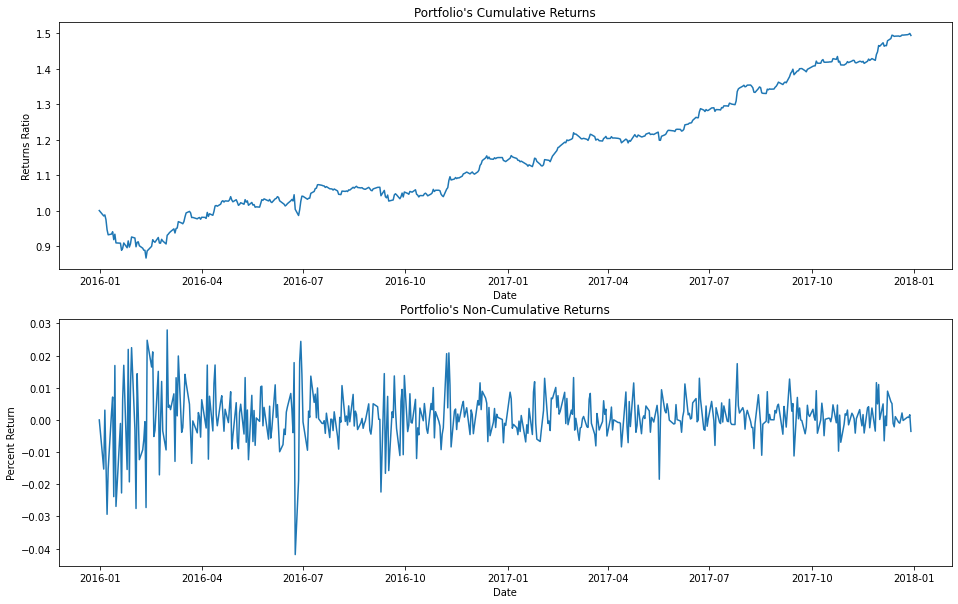

In [10]:
fig, axes = plt.subplots(nrows = 2, figsize = (16,10))
portfolio_cumulative_returns = my_allocation.weighted_cumulative_returns(dummy_weights)
portfolio_non_cumulative_returns = my_allocation.weighted_noncumulative_returns(dummy_weights)

axes[0].plot(portfolio_cumulative_returns.index, portfolio_cumulative_returns)
axes[0].set_title("Portfolio's Cumulative Returns")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Returns Ratio")

axes[1].plot(portfolio_non_cumulative_returns.index, portfolio_non_cumulative_returns)
axes[1].set_title("Portfolio's Non-Cumulative Returns")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Percent Return")
pass

### The Efficient Frontier

- The *Allocation* class has the ability to plot the efficient frontier of the returns you gave it. 
- It does this by uniformly sampling weights from the dirichlet distribution and plotting the results as a point on the returns vs volatility graph
- With enough points, you get a good picture of the possible returns and volatility metrics your portfolio can have

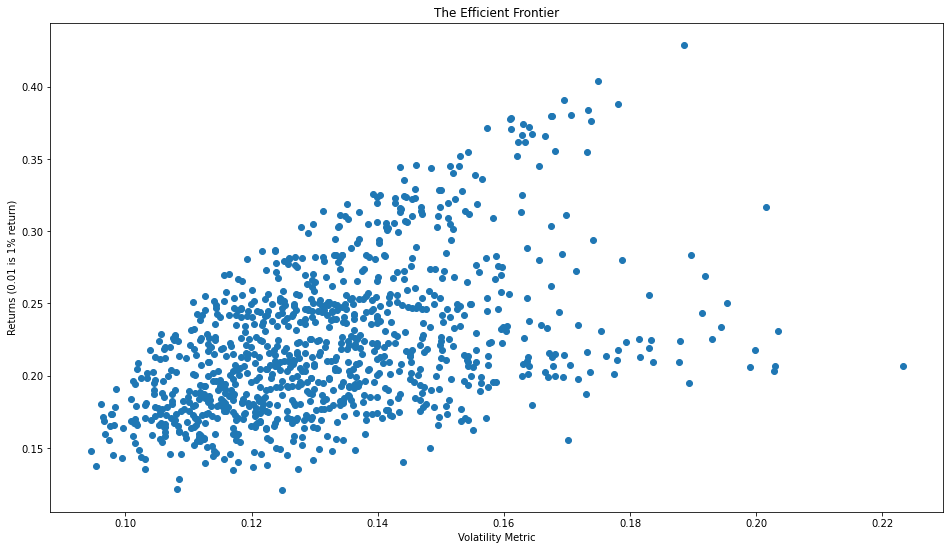

In [11]:
fig, ax = plt.subplots(figsize = (16,9))
my_allocation.plot_efficient_frontier(ax = ax, return_func = my_allocation.portfolio_annual_return, volatility_func = my_allocation.portfolio_annual_std_dev, num_points = 1000)
ax.set_title("The Efficient Frontier")
ax.set_xlabel("Volatility Metric")
ax.set_ylabel("Returns (0.01 is 1% return)")
pass

### Solving for Points of Interest

- The *Allocation* class has multiple possible solvers to choose from:
    - SCIPY minimize
    - A Markov Chain Monte Carlo method
    - Randomly Sampling
- The *Allocation* class has constructors for objective functions that can be readily passed in to the solvers to find points of interest on the efficient frontier
    - *objective_sharpe_ratio* will maximize the sharpe ratio: annualized alpha per annualized standard deviation
    - *objective_std_deviation* will simply minimize the standard deviation

In [12]:
#Generate some objective functions- make sure you know which volatility metric they use, since it makes no sense to plot
#a standard deviation metric on the same plot as a VAR metric
sharpe_objective = my_allocation.objective_sharpe_ratio()
min_vol_objective = my_allocation.objective_std_deviation()

#Pass these objectives into the solver to get the ideal weights
scipy_sharpe_weights = my_allocation.weights_scipy_minimize(sharpe_objective)
scipy_stddev_weights = my_allocation.weights_scipy_minimize(min_vol_objective)

#In the case of the MCMC solver, it also returns the path it takes
MCMC_sharpe_weights, MCMC_sharpe_path = my_allocation.weights_MCMC_minimize(sharpe_objective, steps = 1e4)
MCMC_stddev_weights, MCMC_stddev_path = my_allocation.weights_MCMC_minimize(min_vol_objective, steps = 1e4)

Let's Visualize our performance on the efficient frontier

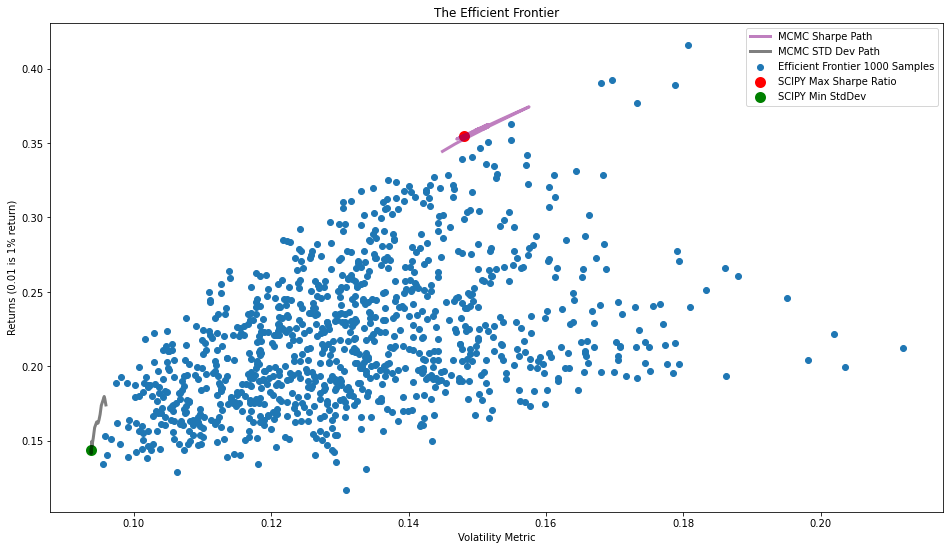

In [13]:
fig, ax = plt.subplots(figsize = (16,9))
my_allocation.plot_efficient_frontier(ax = ax, return_func = my_allocation.portfolio_annual_return, volatility_func = my_allocation.portfolio_annual_std_dev, num_points = 1000)
ax.set_title("The Efficient Frontier")
ax.set_xlabel("Volatility Metric")
ax.set_ylabel("Returns (0.01 is 1% return)")

ax.scatter(x = my_allocation.portfolio_annual_std_dev(scipy_sharpe_weights), y = my_allocation.portfolio_annual_return(scipy_sharpe_weights), label = "SCIPY Max Sharpe Ratio", 
linewidths = 5, color = "Red")
ax.scatter(x = my_allocation.portfolio_annual_std_dev(scipy_stddev_weights), y = my_allocation.portfolio_annual_return(scipy_stddev_weights), label = "SCIPY Min StdDev", 
linewidths = 5, color = "Green")

ax.plot([my_allocation.portfolio_annual_std_dev(w) for w in MCMC_sharpe_path], [my_allocation.portfolio_annual_return(w) for w in MCMC_sharpe_path], 
label = "MCMC Sharpe Path", color = "Purple", linewidth = 3, alpha = 0.5)
ax.plot([my_allocation.portfolio_annual_std_dev(w) for w in MCMC_stddev_path], [my_allocation.portfolio_annual_return(w) for w in MCMC_stddev_path], label = "MCMC STD Dev Path", 
color = "Black", linewidth = 3, alpha = 0.5)

ax.legend()

- Both solvers seem to arrive at similar points on the frontier and from visual inspection, both solvers seem to be in roughly the right place to maximize their respective objectives
- Let's quantify their success, and compare that to the very computationally expensive brute force method of the third solver that generates a number of random portfolios and chooses the one that optimizes the objective the best. 

In [14]:
diagnostic = pd.DataFrame(columns = ["Returns", "Volatiliy", "Sharpe Ratio"])

brute_force_sharpe = my_allocation.weights_uniform_sampling_minimize(sharpe_objective, samples = 1e5)
brute_force_stddev = my_allocation.weights_uniform_sampling_minimize(min_vol_objective, samples = 1e5)

diagnostic.loc["SCIPY Max Sharpe"] = (my_allocation.portfolio_annual_return(scipy_sharpe_weights), my_allocation.portfolio_annual_std_dev(scipy_sharpe_weights), 
my_allocation.portfolio_annual_alpha(scipy_sharpe_weights) / my_allocation.portfolio_annual_std_dev(scipy_sharpe_weights))
diagnostic.loc["SCIPY Min Vol"] = (my_allocation.portfolio_annual_return(scipy_stddev_weights), my_allocation.portfolio_annual_std_dev(scipy_stddev_weights), 
my_allocation.portfolio_annual_alpha(scipy_stddev_weights) / my_allocation.portfolio_annual_std_dev(scipy_stddev_weights))

diagnostic.loc["MCMC Max Sharpe"] = (my_allocation.portfolio_annual_return(MCMC_sharpe_weights), my_allocation.portfolio_annual_std_dev(MCMC_sharpe_weights), 
my_allocation.portfolio_annual_alpha(MCMC_sharpe_weights) / my_allocation.portfolio_annual_std_dev(MCMC_sharpe_weights))
diagnostic.loc["MCMC Min Vol"] = (my_allocation.portfolio_annual_return(MCMC_stddev_weights), my_allocation.portfolio_annual_std_dev(MCMC_stddev_weights), 
my_allocation.portfolio_annual_alpha(MCMC_stddev_weights) / my_allocation.portfolio_annual_std_dev(MCMC_stddev_weights))

diagnostic.loc["Brute Force Max Sharpe"] = (my_allocation.portfolio_annual_return(brute_force_sharpe), my_allocation.portfolio_annual_std_dev(brute_force_sharpe), 
my_allocation.portfolio_annual_alpha(brute_force_sharpe) / my_allocation.portfolio_annual_std_dev(brute_force_sharpe))
diagnostic.loc["Brute Force Min Vol"] = (my_allocation.portfolio_annual_return(brute_force_stddev), my_allocation.portfolio_annual_std_dev(brute_force_stddev), 
my_allocation.portfolio_annual_alpha(brute_force_stddev) / my_allocation.portfolio_annual_std_dev(brute_force_stddev))

In [15]:
diagnostic

,Returns,Volatiliy,Sharpe Ratio
SCIPY Max Sharpe,0.354932,0.148016,2.195254
SCIPY Min Vol,0.143592,0.093803,1.210969
MCMC Max Sharpe,0.354847,0.147977,2.195252
MCMC Min Vol,0.144057,0.093803,1.215924
Brute Force Max Sharpe,0.344238,0.143452,2.190548
Brute Force Min Vol,0.147398,0.093930,1.249849


# Predictive Efficacy
<hr>

- The *Compare_Allocations* class helps with seeing how well these portfolios fare in the future
- Let's use our previous data, divided into a half and half split between train and test data to see how well the first year predicts the second year
- The *Compare_Allocations.get_predictive_efficacy* function finds the ratio of the distance from ideal of the prediction to the distance from ideal of the evenly weighted portfolio.
    - The closer the value is to 0, the better. Where 1 is the break-even point, and any value above that indicates that an arbitrarily chosen even-weighted portfolio works better.

In [17]:
#Create the comparator class
comparator = financial_analysis.Compare_Allocations(price_history= price_history, train_fraction = 0.5)

#It will split the data into the fraction you specified, and create train and test allocations
train_allocation, test_allocation = comparator.get_train_test_split()

#Let's maximize the sharpe ratio
train_objective = train_allocation.objective_sharpe_ratio()
weights_predicted = train_allocation.weights_scipy_minimize(train_objective)

#Now lets see what the ideal solution would have been
test_objective = test_allocation.objective_sharpe_ratio()
weights_true = test_allocation.weights_scipy_minimize(test_objective)

#You can use the comparator to get a proxy for predictive efficacy
distance = comparator.get_predictive_efficacy(ideal_weights = weights_true, predicted_weights = weights_predicted, test_objective = test_objective)
print("The Predictive Efficacy is:", round(distance,3))

The Predictive Efficacy is: 3.051


This seems pretty bad, but let's see what happens if we change the training fraction to be much larger

In [29]:
#Create the comparator class
comparator = financial_analysis.Compare_Allocations(price_history= price_history, train_fraction = 0.90)

#It will split the data into the fraction you specified, and create train and test allocations
train_allocation, test_allocation = comparator.get_train_test_split()

#Let's maximize the sharpe ratio
train_objective = train_allocation.objective_sharpe_ratio()
weights_predicted = train_allocation.weights_scipy_minimize(train_objective)

#Now lets see what the ideal solution would have been
test_objective = test_allocation.objective_sharpe_ratio()
weights_true = test_allocation.weights_scipy_minimize(test_objective)

#You can use the comparator to get a proxy for predictive efficacy
distance = comparator.get_predictive_efficacy(ideal_weights = weights_true, predicted_weights = weights_predicted, test_objective = test_objective)
print("The Predictive Efficacy is:", round(distance,3))

The Predictive Efficacy is: 0.55


This seems pretty good, and it makes sense that having more training data to try and predict shorter time periods would yield better results. However, this is one isolated sample of a small subset of stocks in a relatively short time frame, so no conclusions can be drawn here.

Just to visualize how the train-split affects the distance value- let's plot all splits from 0.5 to 0.95 and their respective distances, as well as a horizontal line at y = 1

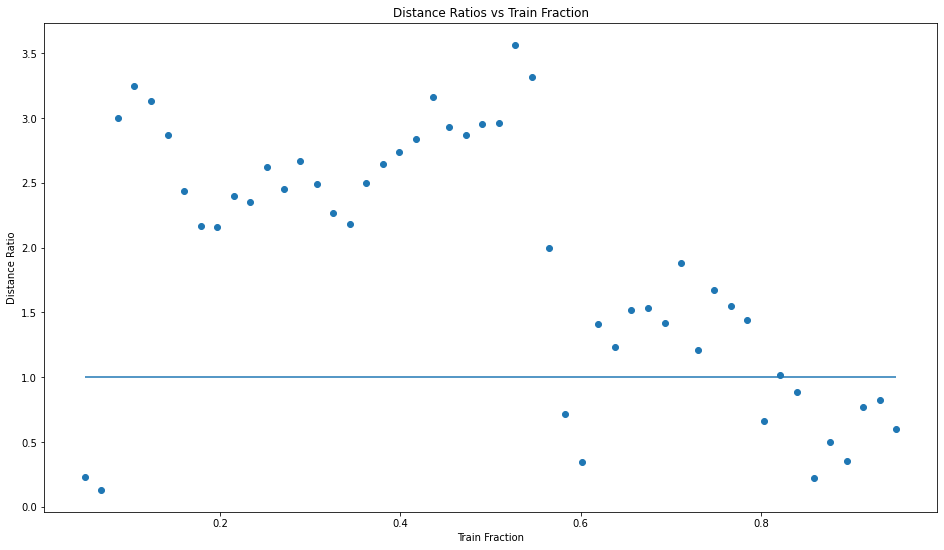

In [39]:
xs = np.linspace(0.05, 0.95)
ys = []

for x in xs:
    comparator = financial_analysis.Compare_Allocations(price_history= price_history, train_fraction = x)
    train_allocation, test_allocation = comparator.get_train_test_split()

    #Let's maximize the sharpe ratio
    train_objective = train_allocation.objective_sharpe_ratio()
    weights_predicted = train_allocation.weights_scipy_minimize(train_objective)

    #Now lets see what the ideal solution would have been
    test_objective = test_allocation.objective_sharpe_ratio()
    weights_true = test_allocation.weights_scipy_minimize(test_objective)

    #You can use the comparator to get a proxy for predictive efficacy
    distance = comparator.get_predictive_efficacy(ideal_weights = weights_true, predicted_weights = weights_predicted, test_objective = test_objective)

    distance = comparator.get_predictive_efficacy(ideal_weights = weights_true, predicted_weights = weights_predicted, test_objective = test_objective)
    ys.append(distance)

fig, ax = plt.subplots(figsize = (16,9))
ax.hlines(1, 0.05, 0.95)
ax.scatter(xs, ys)
ax.set_xlabel("Train Fraction")
ax.set_ylabel("Distance Ratio")
ax.set_title("Distance Ratios vs Train Fraction")
pass

There's a clear trend where larger training fractions tend to yield better predictive ratios as predicted!
The outliers at very small and very large train fractions can be ignored since the data of the train or test allocations will have so little price history their parameters are largely useless.

However, this is one isolated subset of stocks in one isolated time frame of 2 years- much more testing is required to come to any conclusions, but preliminary data seems promising.